PySpark

In [ ]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark


In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import PCA as PCAml
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
path = "/content/BostonHousing.csv"

# (1)Read the CSV file
df = spark.read.csv(path, header = True, inferSchema = True)


# (1) Show the first 5 elements of the dataset
df.show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 5 rows



Task 3 Combine features to a single vector columns using VectorAssembler (all columns other than target column 'medv')

In [ ]:
feature_columns = df.columns[:-1]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_df = assembler.transform(df)

# Standardize features for principal component analysis
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)

# Create a Pipeline
pipeline = Pipeline(stages=[assembler, scaler])
pipeline_model = pipeline.fit(df)
scaled_data = pipeline_model.transform(df)

scaled_data.show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+--------------------+--------------------+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|            features|      scaledFeatures|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+--------------------+--------------------+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|[0.00632,18.0,2.3...|[-0.4193669292132...|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|[0.02731,0.0,7.07...|[-0.4169266699640...|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|[0.02729,0.0,7.07...|[-0.4169289951277...|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|[0.03237,0.0,2.18...|[-0.4163384035610...|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|[0.06905,0.0,2.18...|[-0.4120740534

Task 4 Standardize features for principal component analysis


In [ ]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
scaler_model = scaler.fit(assembled_df)
scaled_data = scaler_model.transform(assembled_df)

Task 5 Train model for two principal component analysis

In [ ]:
pca = PCAml(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_model = pca.fit(scaled_data)
pca_result = pca_model.transform(scaled_data)

Task 6 Collect distributed data in numpy array and then convert to pandas dataframe

In [ ]:
pca_features = pca_result.select("pcaFeatures").rdd.map(lambda row: row[0].toArray()).collect()
pca_df = pd.DataFrame(pca_features, columns=["PC1", "PC2"])

Task 7 Plot two principal components

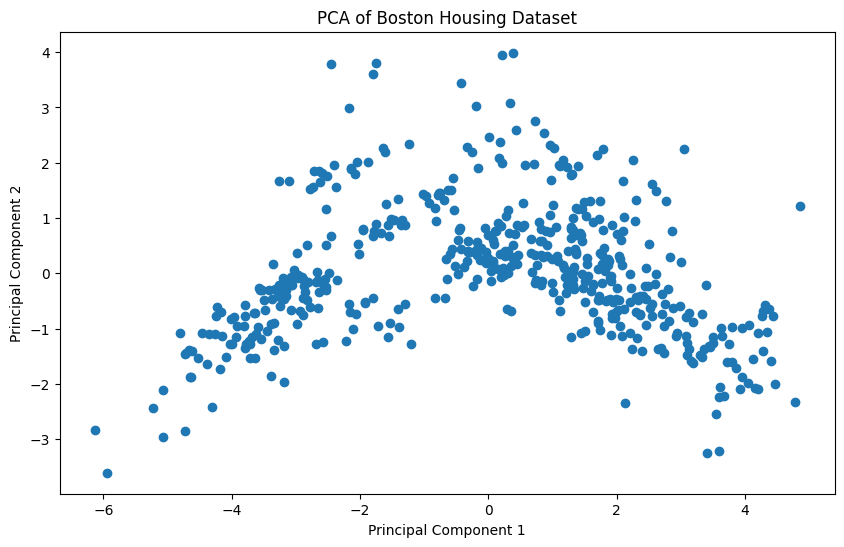

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(pca_df["PC1"], pca_df["PC2"])
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Boston Housing Dataset")
plt.show()

Task 8 Vectorize features and target together for model development


In [ ]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
vectorized_df = assembler.transform(df).select("features", "medv")


Task 9 Split dataset into training and testing dataset

In [ ]:
train_data, test_data = vectorized_df.randomSplit([0.8, 0.2], seed=1234)

Task 10 Fit model for linear regression

In [ ]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol="features", labelCol="medv")
lr_model = lr.fit(train_data)

Task 11 Find out model coefficients and intercept

In [ ]:
coefficients = lr_model.coefficients
intercept = lr_model.intercept
print(f"Coefficients: {coefficients}")
print(f"Intercept: {intercept}")

Coefficients: [-0.11166968641972451,0.0513387390467213,0.06157140227706896,2.1424274525657574,-22.13324118651141,3.8455255967639017,0.005097319974480969,-1.639857270571322,0.3007816839899243,-0.012078932531607512,-1.0727086557243122,0.00865614167805962,-0.5130768636704376]
Intercept: 40.828724013434496


Task 12 Evaluate model for test dataset

In [ ]:
test_result = lr_model.evaluate(test_data)
print(f"RMSE: {test_result.rootMeanSquaredError}")
print(f"R2: {test_result.r2}")

RMSE: 5.042109954192661
R2: 0.6009417230621307


Task 13 Perform further analysis for better interpretation of model results.

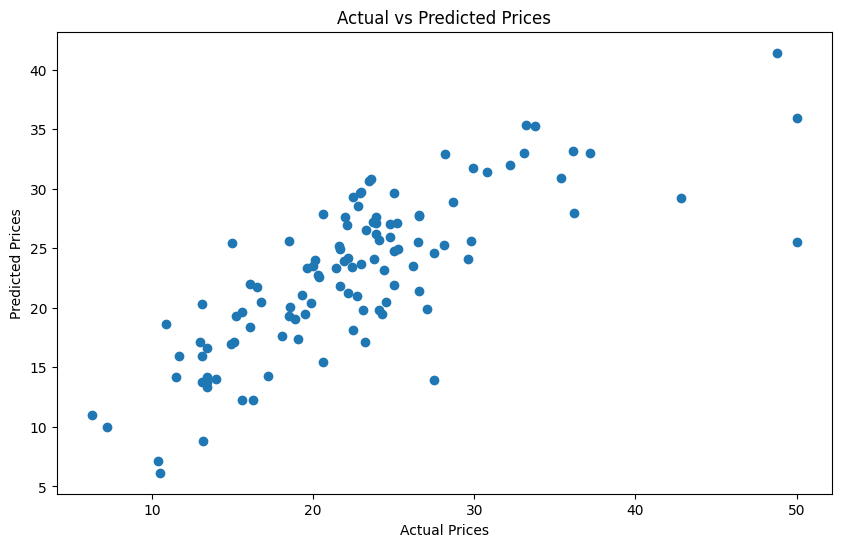

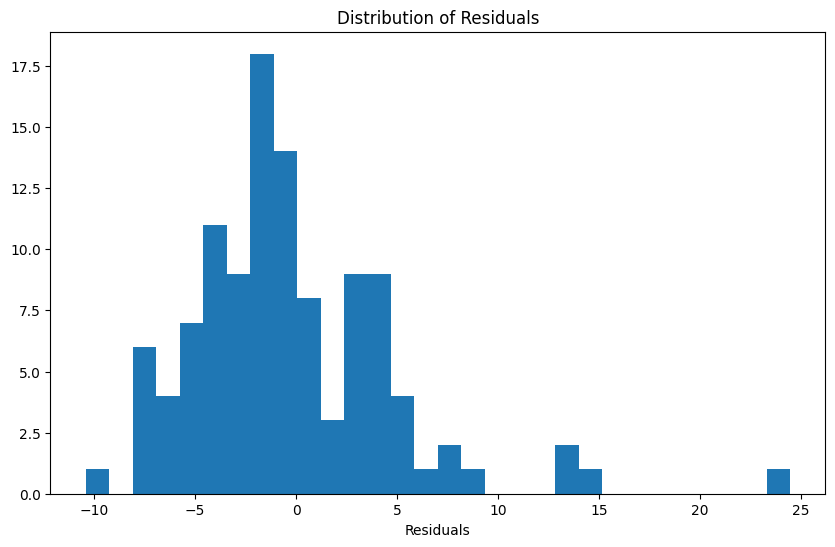

In [ ]:
# Converting test results to a pandas dataframe for further analysis
predictions = test_result.predictions
predictions_df = predictions.toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(predictions_df["medv"], predictions_df["prediction"])
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.show()

# Residuals
residuals = predictions_df["medv"] - predictions_df["prediction"]
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30)
plt.xlabel("Residuals")
plt.title("Distribution of Residuals")
plt.show()

